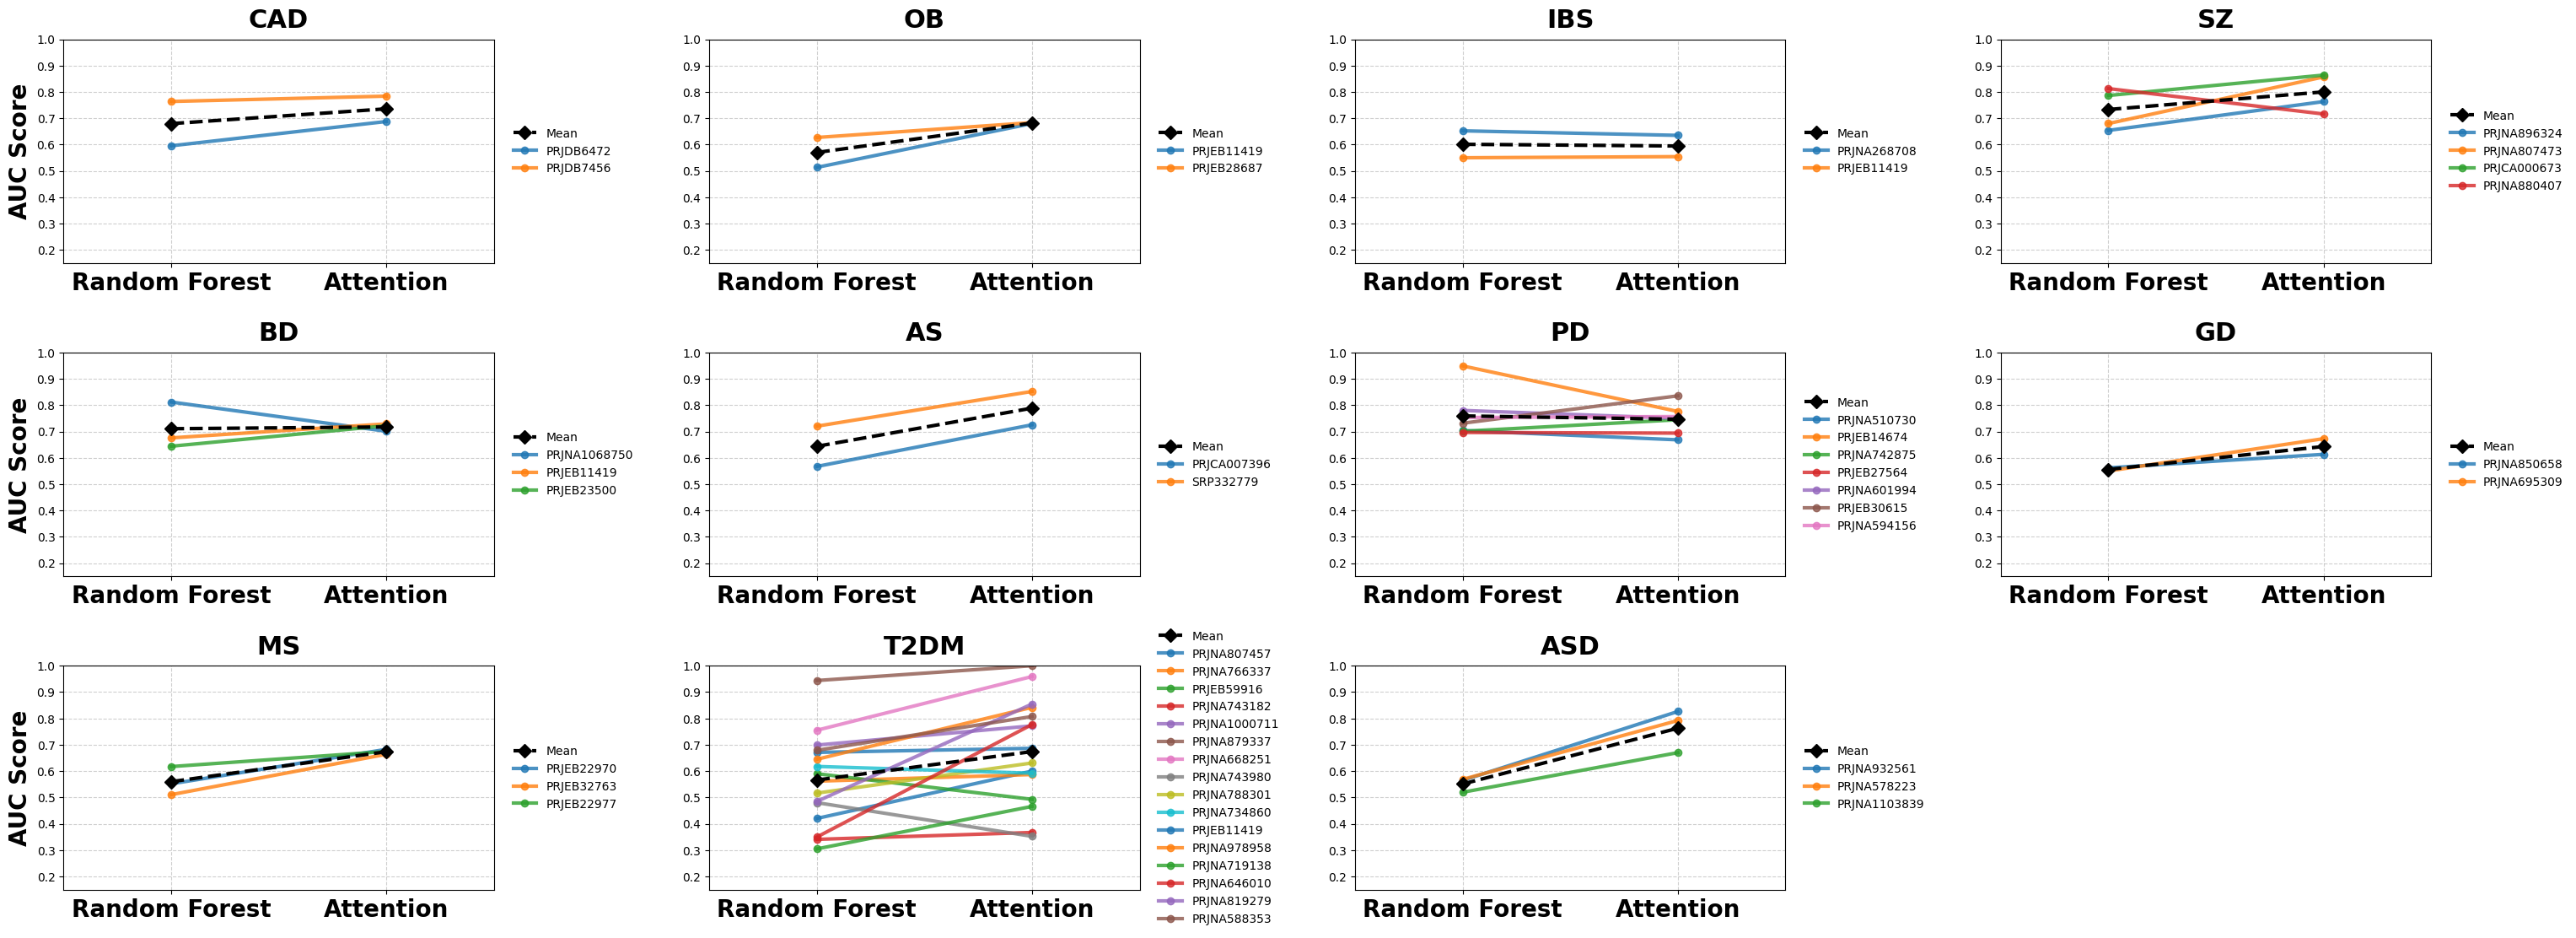

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import math

# 读取CSV数据 ------------------------------------------------
csv_path = "all_model_loo.csv"  # 修改为实际路径
df = pd.read_csv(csv_path)

# 过滤不需要的疾病
df = df[
        (df['disease_name_ab'] != 'HTN') & 
        (df['disease_name_ab'] != 'IBD') & 
        (df['disease_name_ab'] != 'PC') & 
        (df['disease_name_ab'] != 'CRC')].copy()

# 处理重复列
df = df.loc[:,~df.columns.duplicated()].copy()

# 创建子图布局 -----------------------------------------------
diseases = df['disease_name_ab'].unique()
n_diseases = len(diseases)
cols = 4  # 每行4个子图
rows = math.ceil(n_diseases / cols)

# 创建画布并调整间距（关键参数）
fig, axs = plt.subplots(rows, cols, figsize=(cols*9, rows*4))
if rows == 1:
    axs = axs.reshape(1, -1)
fig.subplots_adjust(
    left=0.04,
    right=0.82,  # 增大右侧空间
    top=0.92,
    bottom=0.08,
    hspace=0.4,
    wspace=0.5
)

# 统一可视化参数
model_positions = [0, 1]
xlim_range = (-0.5, 1.5)
cmap = plt.get_cmap('tab10')  # 使用10色循环
marker_style = 'o'
marker_size = 6

# 图例参数配置
legend_params = {
    'bbox_to_anchor': (1.02, 0.5),  # 图例位置
    'loc': 'center left',
    'ncol': 1,
    'fontsize': 10,
    'title_fontsize': 12,
    'frameon': False
}

# 遍历每个疾病绘制子图 ---------------------------------------
for idx, disease in enumerate(diseases):
    row = idx // cols
    col = idx % cols
    ax = axs[row, col] if rows > 1 else axs[col]

    # 筛选数据
    disease_df = df[df['disease_name_ab'] == disease]
    disease_name = disease_df.disease_name_ab.unique()[0]
    
    # 计算平均AUC
    mean_rf = disease_df['AUC ROC'].mean()
    mean_att = disease_df['auc'].mean()

    # 收集图例元素
    legend_handles = []
    legend_labels = []

    # 先绘制平均线（确保在顶部）
    mean_line = ax.plot(
        ['Random Forest', 'Attention'],
        [mean_rf, mean_att],
        color='black',
        linestyle='--',
        linewidth=3,
        marker='D',
        markersize=8,
        zorder=100  # 确保在最上层
    )[0]
    legend_handles.append(mean_line)
    legend_labels.append(f"Mean")

    # 绘制各study连线
    for study_idx, (_, row_data) in enumerate(disease_df.iterrows()):
        color = cmap(study_idx % 10)  # 循环使用颜色
        
        # 绘制连线
        line = ax.plot(
            ['Random Forest', 'Attention'],
            [row_data['AUC ROC'], row_data['auc']],
            color=color,
            alpha=0.8,
            marker=marker_style,
            markersize=marker_size,
            linewidth=3,
        )[0]

        # 添加图例项
        legend_handles.append(line)
        legend_labels.append(
            f"{row_data['study']}"
        )

    # 子图装饰
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xlim(xlim_range)
    ax.set_ylim(0.15, 1)
    ax.set_title(disease, fontsize=22, pad=10, weight='bold')
    ax.set_xticks(model_positions)
    ax.set_xticklabels(['Random Forest', 'Attention'], fontsize=20,weight='bold')
    
    # 仅最左侧子图显示ylabel
    if col == 0:
        ax.set_ylabel('AUC Score', fontsize=20,weight='bold')

    # 添加统一图例（关键修改）
    ax.legend(
        handles=legend_handles,
        labels=legend_labels,
        **legend_params
    )

# 隐藏空白子图
for idx in range(n_diseases, rows*cols):
    row = idx // cols
    col = idx % cols
    axs[row, col].axis('off')

# 保存高清图像
plt.savefig('auc_comparison_optimized.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def plot_study_roc(study_path, ax):
    """在指定的axes上绘制单个study的ROC曲线"""
    # 定义文件路径
    attention_path = os.path.join(study_path, "attention_roc.csv")
    rf_path = os.path.join(study_path, "RF_ROC.csv")
    
    # 读取数据
    attention_df = pd.read_csv(attention_path)
    rf_df = pd.read_csv(rf_path)
    
    # 计算AUC值
    attention_auc = auc(attention_df['FPR'], attention_df['TPR'])
    rf_auc = auc(rf_df['FPR'], rf_df['TPR'])
    
    # 绘制Attention模型ROC曲线
    ax.plot(attention_df['FPR'], attention_df['TPR'], 
            color='#1f77b4', lw=1.5, linestyle='-',
            label=f'Attention (AUC = {attention_auc:.3f})')
    
    # 绘制随机森林ROC曲线
    ax.plot(rf_df['FPR'], rf_df['TPR'],
            color='#ff7f0e', lw=1.5, linestyle='--',
            label=f'RF (AUC = {rf_auc:.3f})')
    
    # 绘制参考线
    ax.plot([0, 1], [0, 1], color='gray', lw=1, linestyle=':')
    
    # 子图装饰
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('FPR', fontsize=9)
    ax.set_ylabel('TPR', fontsize=9)
    ax.set_title(os.path.basename(study_path), fontsize=10, pad=8)
    ax.legend(loc='lower right', fontsize=8, frameon=False)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', labelsize=8)

def plot_group_rocs(grouped_studies, output_dir="results"):
    """绘制分组研究的ROC曲线组图"""
    os.makedirs(output_dir, exist_ok=True)
    
    for group_idx, disease_group in enumerate(grouped_studies):
        # 过滤无效路径并创建完整路径
        study_paths = [
            os.path.join("/home/dongbiao/all_study/result", study)
            for study in disease_group
            if os.path.exists(os.path.join("/home/dongbiao/all_study/result", study))
        ]
        
        if not study_paths:
            continue
        
        # 动态计算子图布局
        num_studies = len(study_paths)
        ncols = 3  # 每行最多3个子图
        nrows = int(np.ceil(num_studies / ncols))
        
        # 创建画布
        fig, axes = plt.subplots(nrows, ncols, figsize=(15, 4*nrows), dpi=150)
        if nrows == 1 and ncols == 1:
            axes = np.array([[axes]])
        elif nrows == 1 or ncols == 1:
            axes = axes.reshape(-1, 1)
            
        # 遍历所有子图位置
        for i in range(nrows):
            for j in range(ncols):
                ax_idx = i * ncols + j
                if ax_idx >= num_studies:
                    # 隐藏多余子图
                    axes[i][j].axis('off')
                    continue
                
                study_path = study_paths[ax_idx]
                plot_study_roc(study_path, axes[i][j])
        
        # 添加大标题和调整布局
        plt.suptitle(f"ROC Curve Comparison - Group {group_idx+1}", 
                    fontsize=14, y=1.02)
        plt.tight_layout(pad=2.0, h_pad=3.0, w_pad=2.0)
        
        # 保存图片
        output_path = os.path.join(output_dir, f"ROC_Group_{group_idx+1}.png")
        plt.savefig(output_path, bbox_inches='tight')
        plt.close()


plot_group_rocs(grouped_studies)

/home/dongbiao/tmp/ipykernel_98328/1874547058.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20')


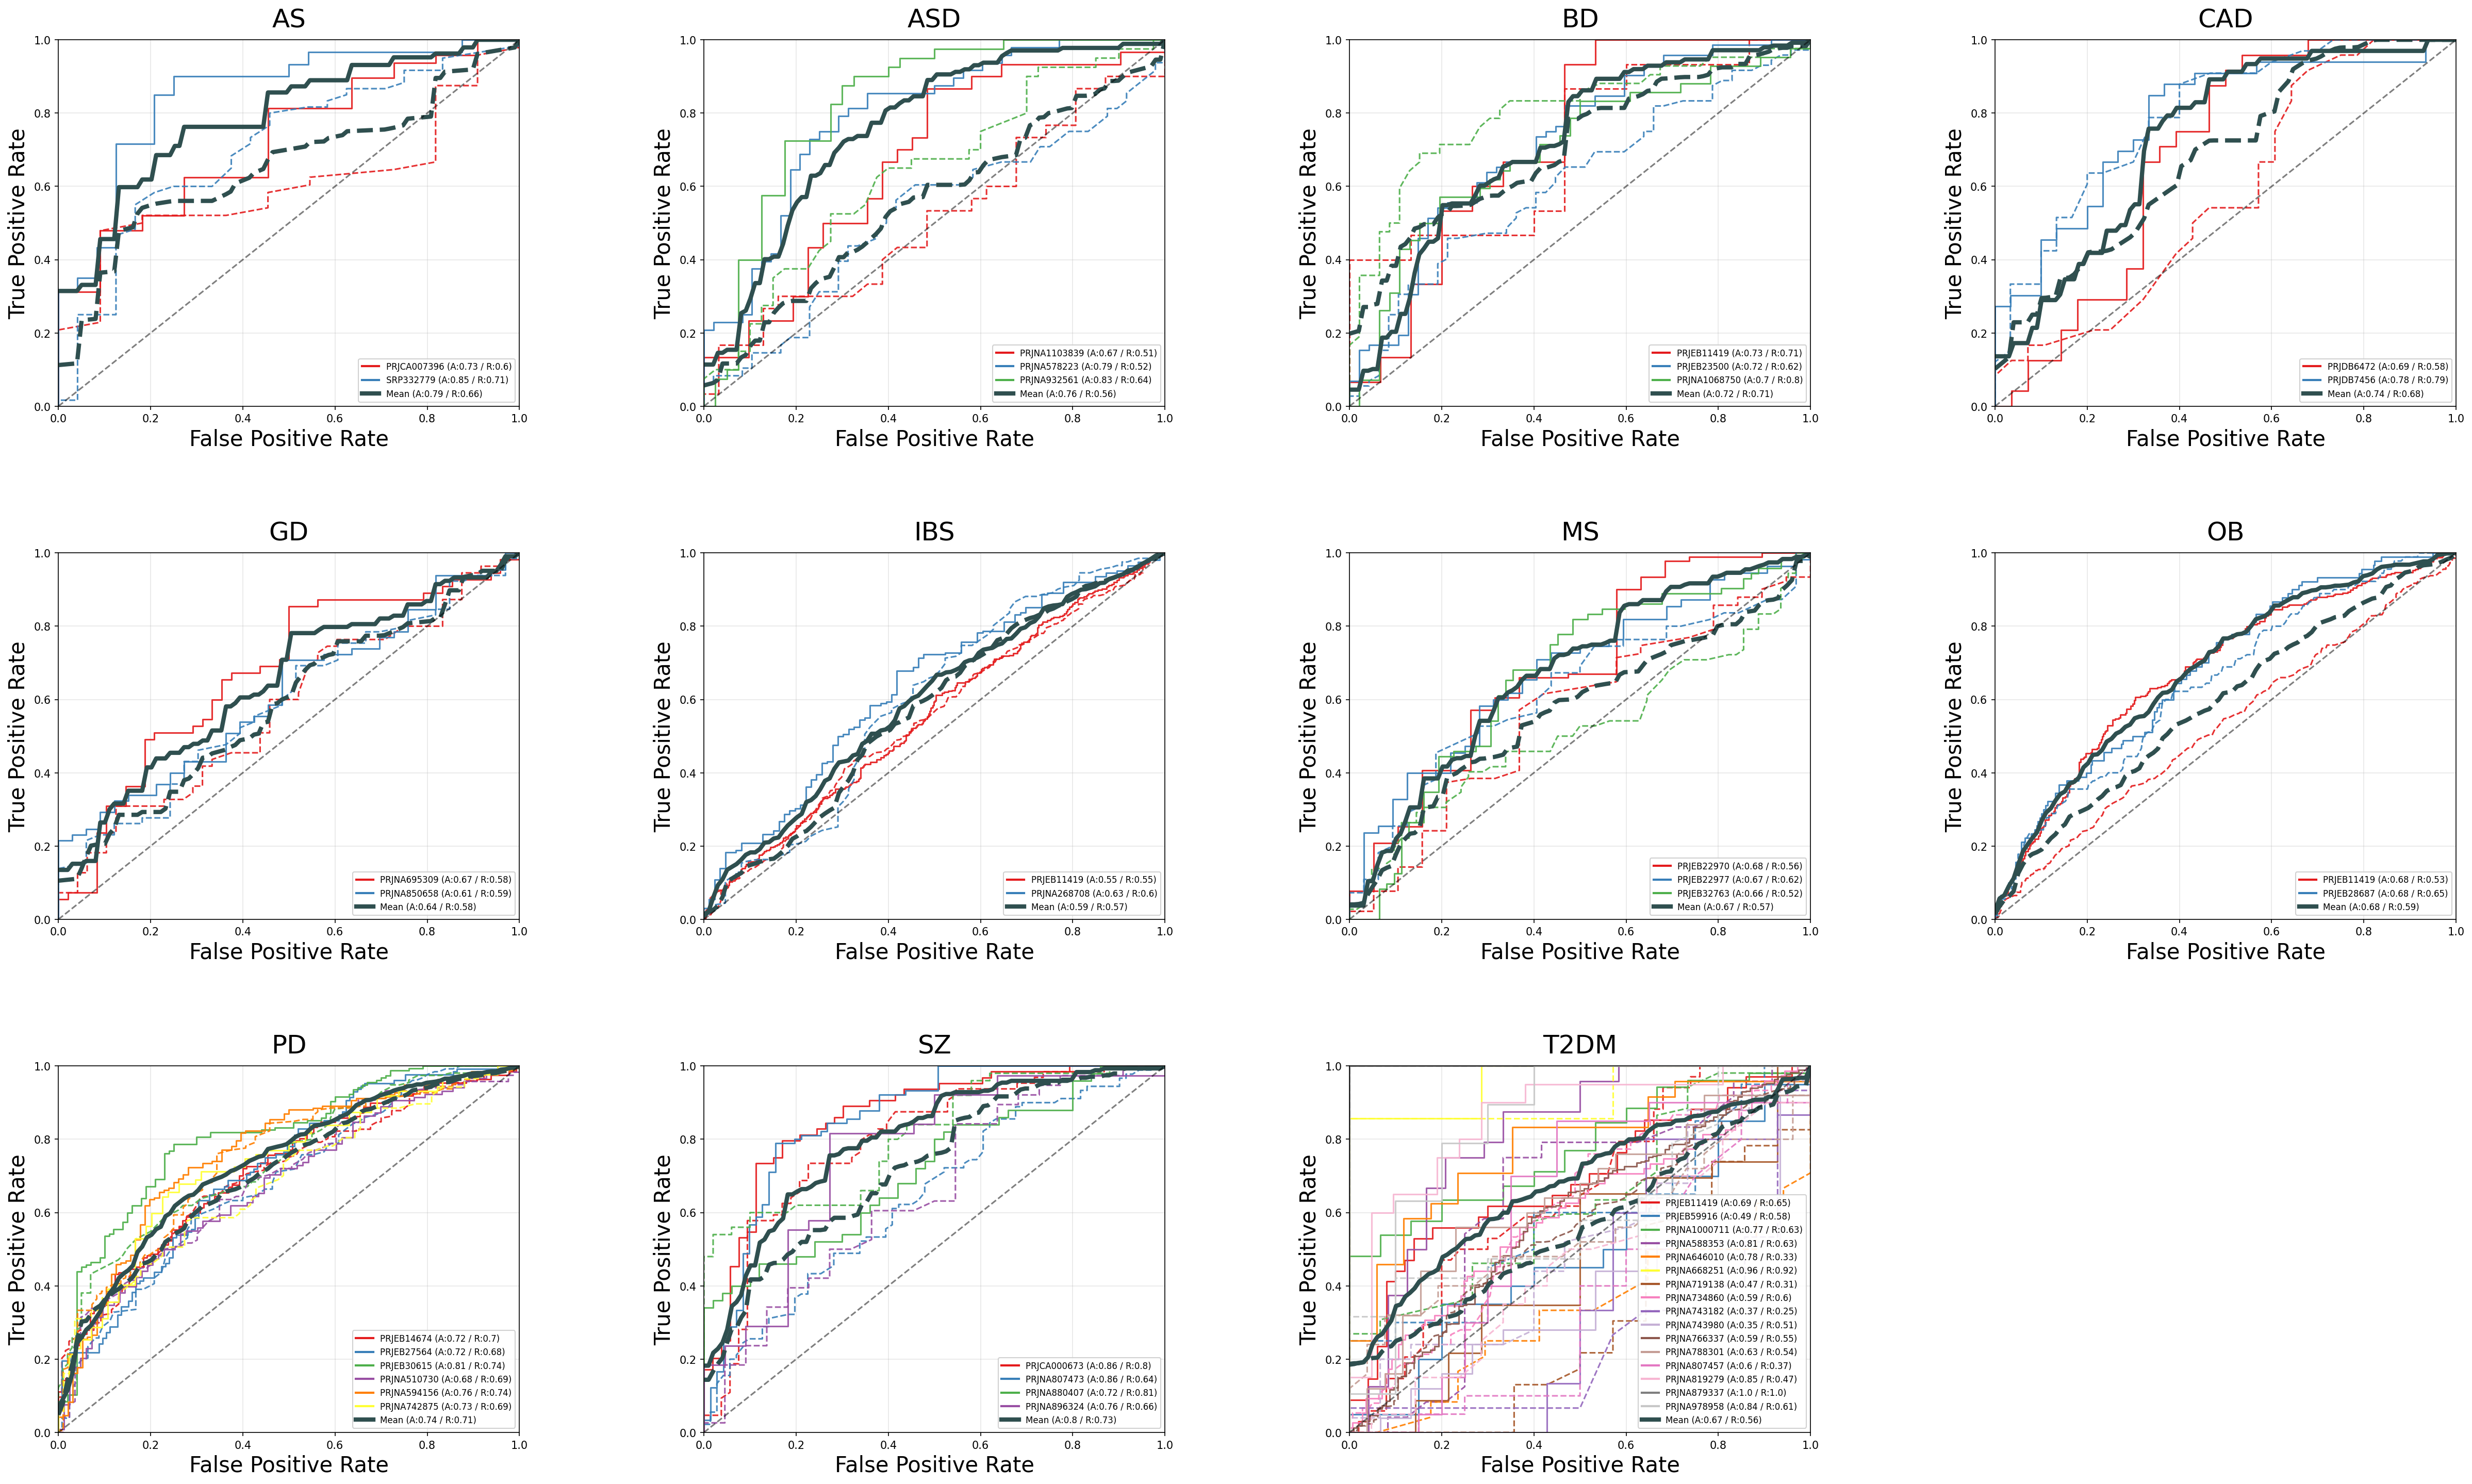

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import auc
import math

# 配置全局参数
plt.rcParams['axes.unicode_minus'] = False

# 路径配置
data_path = "all_model_loo.csv"
result_base = "/home/dongbiao/all_study/result_new"

# 读取数据
df = pd.read_csv(data_path)
disease_studies = df.groupby('disease_name_ab')['study'].unique().apply(sorted).to_dict()

# 计算画布布局
n_diseases = len(disease_studies)
cols = 4
rows = math.ceil(n_diseases / cols)

# 创建自适应画布
fig = plt.figure(figsize=(cols*10, rows*8), dpi=150)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# 颜色配置
def get_distinct_colors(n):
    """生成视觉区分度高的颜色序列"""
    base_colors = [
        '#E41A1C', '#377EB8', '#4DAF4A', '#984EA3',
        '#FF7F00', '#FFFF33', '#A65628', '#F781BF'
    ]
    if n > len(base_colors):
        cmap = plt.cm.get_cmap('tab20')
        return base_colors + [cmap(i) for i in range(len(base_colors), n)]
    return base_colors[:n]

mean_colors = {'attention': '#2F4F4F', 'rf': '#2F4F4F'}


# +++ 新增代码：强制添加端点 +++
def enforce_endpoints(df):
    """确保ROC曲线包含(0,0)和(1,1)端点并进行规范化处理"""
    # 创建端点数据框
    start_point = pd.DataFrame({'FPR': [0.0], 'TPR': [0.0]})
    end_point = pd.DataFrame({'FPR': [1.0], 'TPR': [1.0]})
    
    # 合并端点并去重排序
    df = pd.concat([start_point, df, end_point])
    df = df.sort_values(by='FPR', ascending=True)
    df = df.drop_duplicates(subset='FPR', keep='first')
    
    # 确保端点存在
    if df.iloc[0]['FPR'] > 0:
        df = pd.concat([start_point, df])
    if df.iloc[-1]['FPR'] < 1.0:
        df = pd.concat([df, end_point])
    
    # 再次排序去重
    df = df.sort_values(by='FPR').drop_duplicates(subset='FPR')
    return df.reset_index(drop=True)

bias_index = 0

for idx, (disease_ab, studies) in enumerate(disease_studies.items(), 1):
    if disease_ab in ['HTN', 'IBD', 'CRC','PC']:
        bias_index += 1
        continue

    ax = fig.add_subplot(rows, cols, idx-bias_index)
    colors = get_distinct_colors(len(studies))
    
    # 初始化存储
    all_attn_tpr = []
    all_rf_tpr = []
    attn_aucs = []
    rf_aucs = []
    fpr_common = np.linspace(0, 1, 100)
    
    # 准备图例元素
    legend_handles = []
    legend_labels = []
    
    for study_idx, study in enumerate(studies):

        study_dir = os.path.join(result_base, disease_ab, study, 'results')  # 新增疾病目录层和results目录
        study_dir_RF = os.path.join(result_base, disease_ab, study, 'RF')  # 新增疾病目录层和results目录
        try:
            # 加载数据
            rf_roc = pd.read_csv(os.path.join(study_dir_RF, "RF_ROC.csv"))
            attn_roc = pd.read_csv(os.path.join(study_dir, "roc_curve.csv"))

            # # 添加0,0 1,1端点
            # rf_roc = enforce_endpoints(rf_roc)
            # attn_roc = enforce_endpoints(attn_roc)

            # 计算AUC
            rf_auc = round(auc(rf_roc['FPR'], rf_roc['TPR']), 2)
            attn_auc = round(auc(attn_roc['FPR'], attn_roc['TPR']), 2)
            attn_aucs.append(attn_auc)
            rf_aucs.append(rf_auc)

            # 插值处理
            attn_tpr_interp = np.interp(fpr_common, attn_roc['FPR'], attn_roc['TPR'])
            rf_tpr_interp = np.interp(fpr_common, rf_roc['FPR'], rf_roc['TPR'])
            all_attn_tpr.append(attn_tpr_interp)
            all_rf_tpr.append(rf_tpr_interp)

            color = colors[study_idx]
            
            # 绘制曲线
            ax.plot(attn_roc['FPR'], attn_roc['TPR'],
                    color=color, linestyle='-', linewidth=1.5, alpha=0.9)
            ax.plot(rf_roc['FPR'], rf_roc['TPR'],
                    color=color, linestyle='--', linewidth=1.5, alpha=0.9)

            # 收集图例元素
            legend_handles.append(
                plt.Line2D([], [], color=color, linestyle='-', linewidth=2)
            )
            legend_labels.append(f"{study} (A:{attn_auc} / R:{rf_auc})")

        except Exception as e:
            print(f"Error processing {study}: {str(e)}")
            continue

    # 计算平均AUC
    mean_attn_auc = round(np.mean(attn_aucs), 2) if attn_aucs else 0.0
    mean_rf_auc = round(np.mean(rf_aucs), 2) if rf_aucs else 0.0

    # 绘制平均曲线
    if len(all_attn_tpr) > 0:
        mean_attn = np.mean(all_attn_tpr, axis=0)
        mean_rf = np.mean(all_rf_tpr, axis=0)
        
        ax.plot(fpr_common, mean_attn,
                color=mean_colors['attention'], linestyle='-',
                linewidth=4)
        ax.plot(fpr_common, mean_rf,
                color=mean_colors['rf'], linestyle='--',
                linewidth=4)

    # 添加平均图例项
    legend_handles.extend([
        plt.Line2D([], [], color=mean_colors['attention'], linestyle='-', linewidth=4),
    ])
    legend_labels.extend([
        f"Mean (A:{mean_attn_auc} / R:{mean_rf_auc})",
    ])

    # 配置坐标轴
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    # ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    ax.set(xlim=[0, 1], ylim=[0, 1])
    ax.set_title(f"{disease_ab}", fontsize=24, pad=12)
    ax.set_xlabel('False Positive Rate', fontsize=20)
    ax.set_ylabel('True Positive Rate', fontsize=20)
    ax.grid(True, alpha=0.3)
    
    # 创建统一图例
    ax.legend(
        legend_handles, legend_labels,
        loc='lower right',
        fontsize=8,
        # title='Studies with AUC Values\n(A=Attention, R=RF)',
        # title_fontsize=9,
        handlelength=2,
        framealpha=0.9
    )

#保存图像
plt.savefig("combined_roc.png",
            bbox_inches='tight',
            dpi=300,
            facecolor='white')
plt.show()

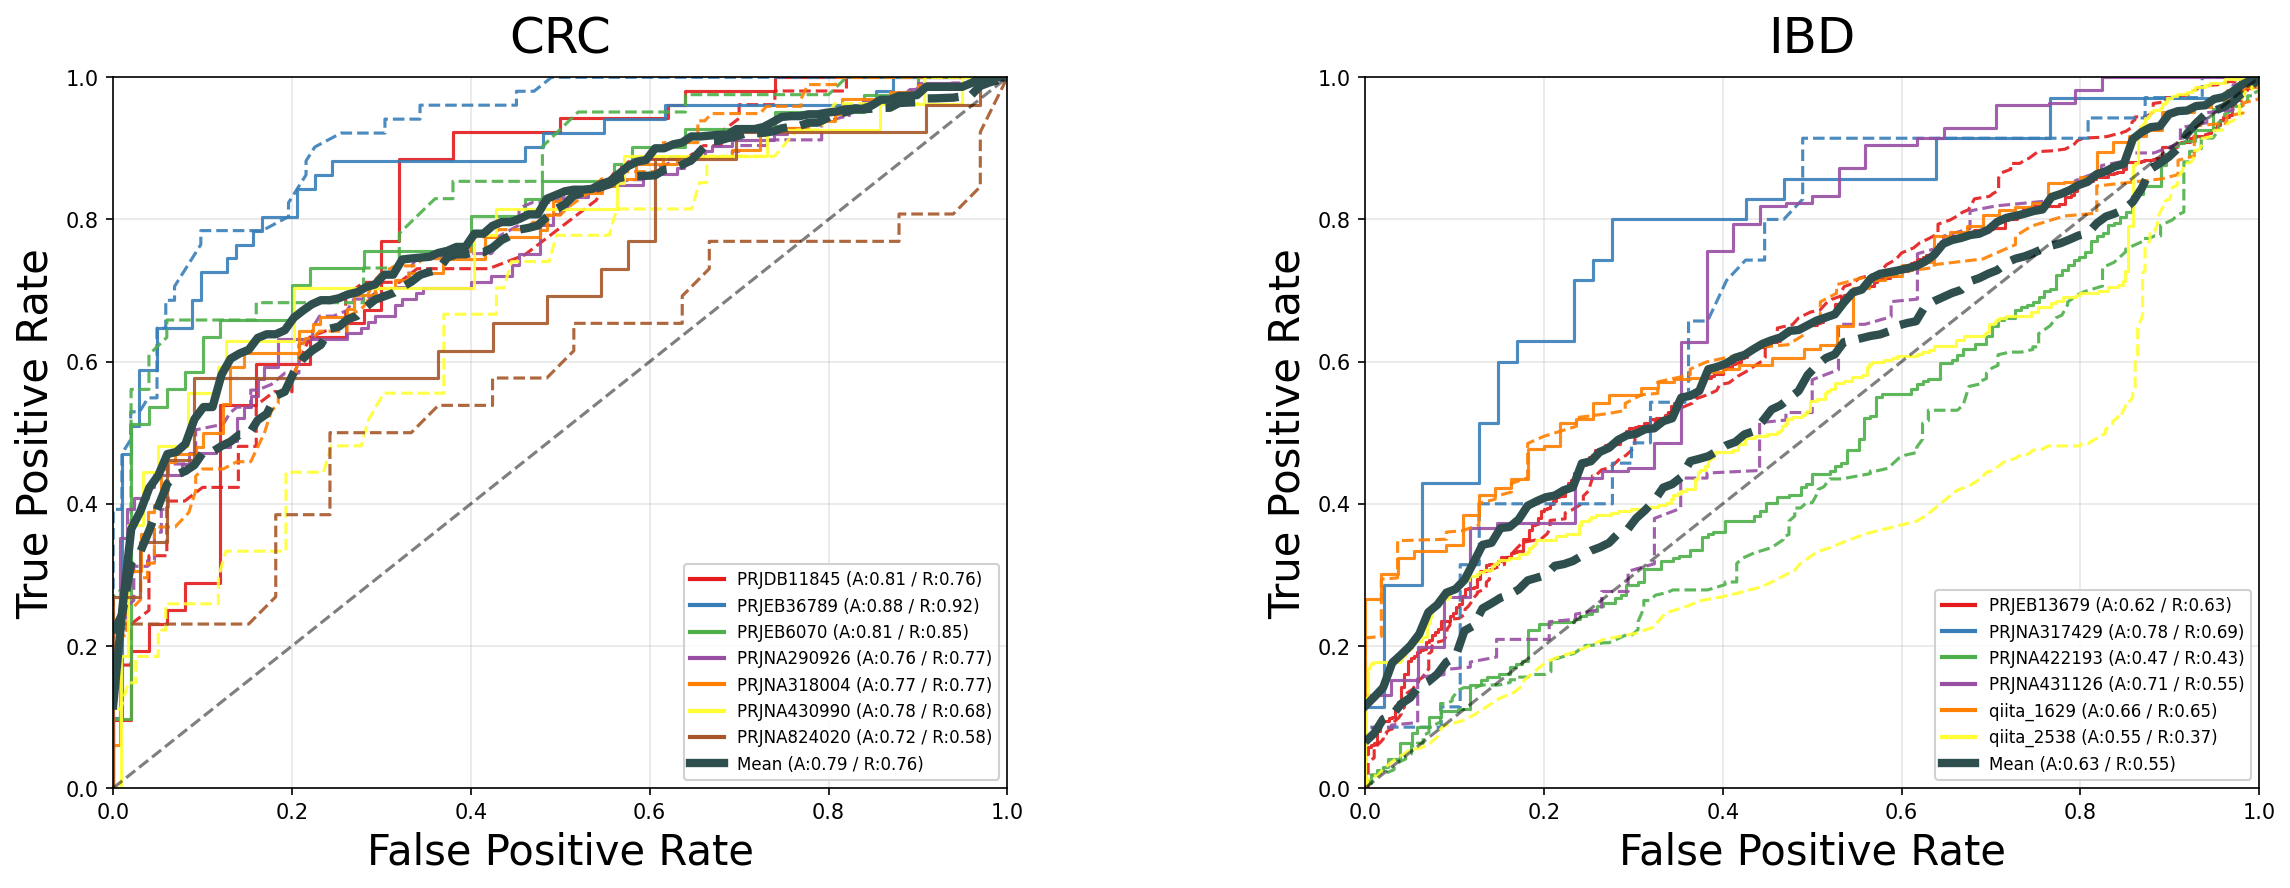

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import auc
import math

# 配置全局参数
plt.rcParams['axes.unicode_minus'] = False

# 路径配置
data_path = "all_model_loo.csv"
result_base = "/home/dongbiao/all_study/result_new"

# 读取数据
df = pd.read_csv(data_path)
disease_studies = df.groupby('disease_name_ab')['study'].unique().apply(sorted).to_dict()

# 计算画布布局
n_diseases = len(disease_studies)
cols = 4
rows = math.ceil(n_diseases / cols)

# 创建自适应画布
fig = plt.figure(figsize=(cols*10, rows*8), dpi=150)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# 颜色配置
def get_distinct_colors(n):
    """生成视觉区分度高的颜色序列"""
    base_colors = [
        '#E41A1C', '#377EB8', '#4DAF4A', '#984EA3',
        '#FF7F00', '#FFFF33', '#A65628', '#F781BF'
    ]
    if n > len(base_colors):
        cmap = plt.cm.get_cmap('tab20')
        return base_colors + [cmap(i) for i in range(len(base_colors), n)]
    return base_colors[:n]

mean_colors = {'attention': '#2F4F4F', 'rf': '#2F4F4F'}


# +++ 新增代码：强制添加端点 +++
def enforce_endpoints(df):
    """确保ROC曲线包含(0,0)和(1,1)端点并进行规范化处理"""
    # 创建端点数据框
    start_point = pd.DataFrame({'FPR': [0.0], 'TPR': [0.0]})
    end_point = pd.DataFrame({'FPR': [1.0], 'TPR': [1.0]})
    
    # 合并端点并去重排序
    df = pd.concat([start_point, df, end_point])
    df = df.sort_values(by='FPR', ascending=True)
    df = df.drop_duplicates(subset='FPR', keep='first')
    
    # 确保端点存在
    if df.iloc[0]['FPR'] > 0:
        df = pd.concat([start_point, df])
    if df.iloc[-1]['FPR'] < 1.0:
        df = pd.concat([df, end_point])
    
    # 再次排序去重
    df = df.sort_values(by='FPR').drop_duplicates(subset='FPR')
    return df.reset_index(drop=True)

bias_index = 0

for idx, (disease_ab, studies) in enumerate(disease_studies.items(), 1):
    if disease_ab not in ['IBD', 'CRC']:
        bias_index += 1
        continue

    ax = fig.add_subplot(rows, cols, idx-bias_index)
    colors = get_distinct_colors(len(studies))
    
    # 初始化存储
    all_attn_tpr = []
    all_rf_tpr = []
    attn_aucs = []
    rf_aucs = []
    fpr_common = np.linspace(0, 1, 100)
    
    # 准备图例元素
    legend_handles = []
    legend_labels = []
    
    for study_idx, study in enumerate(studies):

        study_dir = os.path.join(result_base, disease_ab, study, 'results')  # 新增疾病目录层和results目录
        study_dir_RF = os.path.join(result_base, disease_ab, study, 'RF')  # 新增疾病目录层和results目录
        try:
            # 加载数据
            rf_roc = pd.read_csv(os.path.join(study_dir_RF, "RF_ROC.csv"))
            attn_roc = pd.read_csv(os.path.join(study_dir, "roc_curve.csv"))

            # # 添加0,0 1,1端点
            # rf_roc = enforce_endpoints(rf_roc)
            # attn_roc = enforce_endpoints(attn_roc)

            # 计算AUC
            rf_auc = round(auc(rf_roc['FPR'], rf_roc['TPR']), 2)
            attn_auc = round(auc(attn_roc['FPR'], attn_roc['TPR']), 2)
            attn_aucs.append(attn_auc)
            rf_aucs.append(rf_auc)

            # 插值处理
            attn_tpr_interp = np.interp(fpr_common, attn_roc['FPR'], attn_roc['TPR'])
            rf_tpr_interp = np.interp(fpr_common, rf_roc['FPR'], rf_roc['TPR'])
            all_attn_tpr.append(attn_tpr_interp)
            all_rf_tpr.append(rf_tpr_interp)

            color = colors[study_idx]
            
            # 绘制曲线
            ax.plot(attn_roc['FPR'], attn_roc['TPR'],
                    color=color, linestyle='-', linewidth=1.5, alpha=0.9)
            ax.plot(rf_roc['FPR'], rf_roc['TPR'],
                    color=color, linestyle='--', linewidth=1.5, alpha=0.9)

            # 收集图例元素
            legend_handles.append(
                plt.Line2D([], [], color=color, linestyle='-', linewidth=2)
            )
            legend_labels.append(f"{study} (A:{attn_auc} / R:{rf_auc})")

        except Exception as e:
            print(f"Error processing {study}: {str(e)}")
            continue

    # 计算平均AUC
    mean_attn_auc = round(np.mean(attn_aucs), 2) if attn_aucs else 0.0
    mean_rf_auc = round(np.mean(rf_aucs), 2) if rf_aucs else 0.0

    # 绘制平均曲线
    if len(all_attn_tpr) > 0:
        mean_attn = np.mean(all_attn_tpr, axis=0)
        mean_rf = np.mean(all_rf_tpr, axis=0)
        
        ax.plot(fpr_common, mean_attn,
                color=mean_colors['attention'], linestyle='-',
                linewidth=4)
        ax.plot(fpr_common, mean_rf,
                color=mean_colors['rf'], linestyle='--',
                linewidth=4)

    # 添加平均图例项
    legend_handles.extend([
        plt.Line2D([], [], color=mean_colors['attention'], linestyle='-', linewidth=4),
    ])
    legend_labels.extend([
        f"Mean (A:{mean_attn_auc} / R:{mean_rf_auc})",
    ])

    # 配置坐标轴
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    # ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    ax.set(xlim=[0, 1], ylim=[0, 1])
    ax.set_title(f"{disease_ab}", fontsize=24, pad=12)
    ax.set_xlabel('False Positive Rate', fontsize=20)
    ax.set_ylabel('True Positive Rate', fontsize=20)
    ax.grid(True, alpha=0.3)
    
    # 创建统一图例
    ax.legend(
        legend_handles, legend_labels,
        loc='lower right',
        fontsize=8,
        # title='Studies with AUC Values\n(A=Attention, R=RF)',
        # title_fontsize=9,
        handlelength=2,
        framealpha=0.9
    )

#保存图像
plt.savefig("combined_roc_IBD_CRC.png",
            bbox_inches='tight',
            dpi=300,
            facecolor='white')
plt.show()

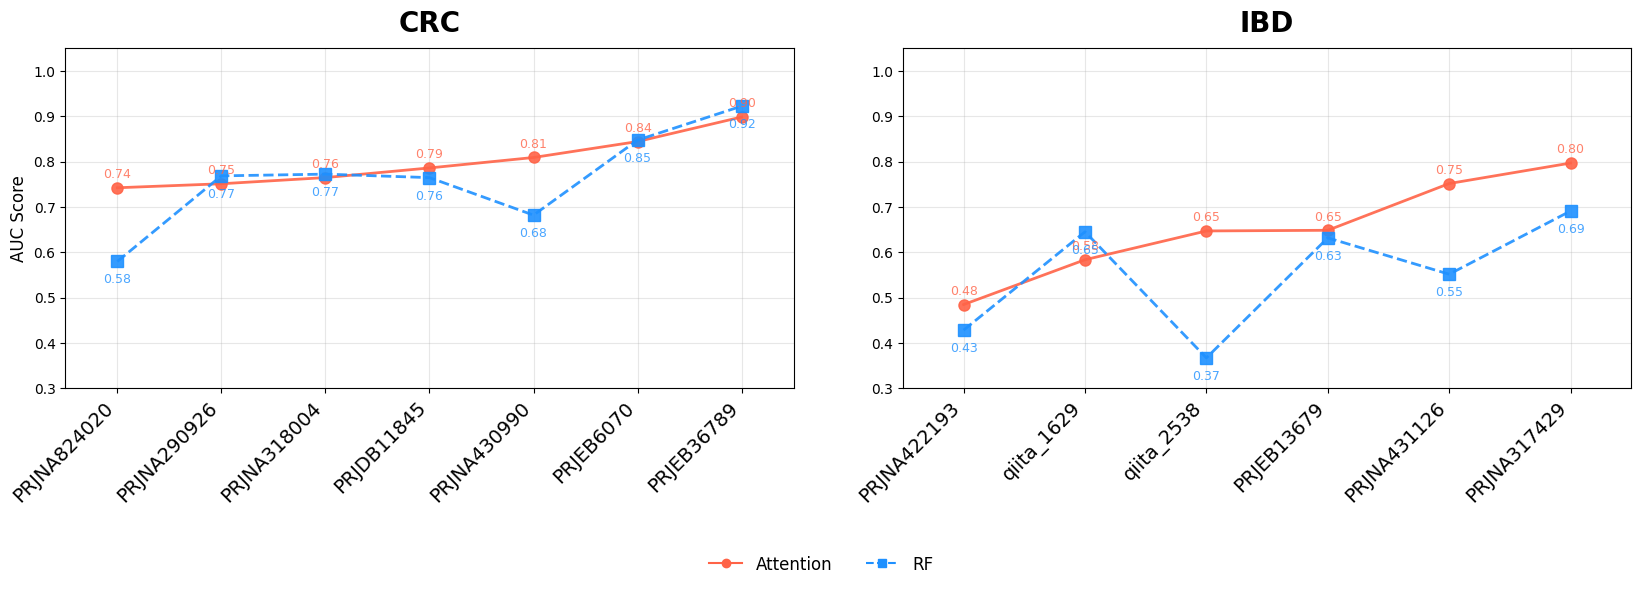

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline

# 读取数据
df = pd.read_csv("/home/dongbiao/all_study/script/script_leave_one_out_new/all_model_loo.csv")
df.columns = [col.strip() for col in df.columns]

# 过滤只保留 IBD 和 CRC
df = df.loc[df['disease_name_ab'].isin(['IBD', 'CRC'])]
diseases = df['disease_name_ab'].unique()

# 创建子图布局
n_diseases = len(diseases)
n_cols = 2
n_rows = math.ceil(n_diseases / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.ravel()  # 关键修复：强制展平为一维数组

# 全局样式设置
style_config = {
    'Attention': {'color': 'tomato', 'marker': 'o', 'ls': '-', 'label': 'Attention AUC'},
    'RF': {'color': 'dodgerblue', 'marker': 's', 'ls': '--', 'label': 'RF AUC ROC'}
}

# 遍历每个疾病绘制子图
for idx, (disease, group) in enumerate(df.groupby('disease_name_ab')):
    ax = axes[idx]

    sorted_group = group.copy()
    # 按 Attention 的 AUC 值降序排序
    sorted_group = sorted_group.sort_values(by='auc', ascending=True)
    
    # 提取当前疾病数据
    studies = sorted_group['study'].tolist()
    x_ticks = range(len(studies))
    
    # 绘制双指标线
    for model in ['Attention', 'RF']:
        metric = 'auc' if model == 'Attention' else 'AUC ROC'
        values = sorted_group[metric].astype(float)
        ax.plot(x_ticks, values, 
                **style_config[model], 
                markersize=8,
                linewidth=2,
                alpha=0.9)
        
        # 添加数值标签
        for x, y in zip(x_ticks, values):
            vertical_offset = 0.03 if model == 'Attention' else -0.04
            ax.text(x, y + vertical_offset, f'{y:.2f}',
                    color=style_config[model]['color'],
                    ha='center', va='center',
                    fontsize=9, alpha=0.8)

    # 子图装饰
    ax.set_xlim(-0.5, len(studies) - 0.5)
    ax.set_title(disease, fontsize=20, pad=12, weight='bold')
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(studies, rotation=45, ha='right', fontsize=14)
    ax.set_ylim(0.3, 1.05)
    ax.grid(True, alpha=0.3)
    ax.set_ylabel('AUC Score', fontsize=12)
    
    # 只在第一列显示ylabel
    if idx % n_cols != 0:
        ax.set_ylabel('')

# 隐藏多余子图
for idx in range(n_diseases, len(axes)):
    axes[idx].axis('off')

# 添加全局图例
handles = [plt.Line2D([], [], **style_config['Attention']),
           plt.Line2D([], [], **style_config['RF'])]
fig.legend(handles=handles, 
           labels=['Attention', 'RF'],
           loc='lower center', 
           bbox_to_anchor=(0.5, -0.05 if n_rows>1 else -0.15),
           ncol=2, 
           fontsize=12,
           frameon=False)

plt.tight_layout(pad=2.0)
# plt.subplots_adjust(bottom=0.15 if n_rows>1 else 0.25)
plt.subplots_adjust(
    left=0.08,    # 左边距
    right=0.95,   # 右边距
    top=0.93,     # 顶部边距
    bottom=0.15 if n_rows>1 else 0.25,  # 底部边距
    wspace=0.15,   # 列间距（关键参数，值越小越紧凑）
    hspace=0.3    # 行间距
)
plt.show()

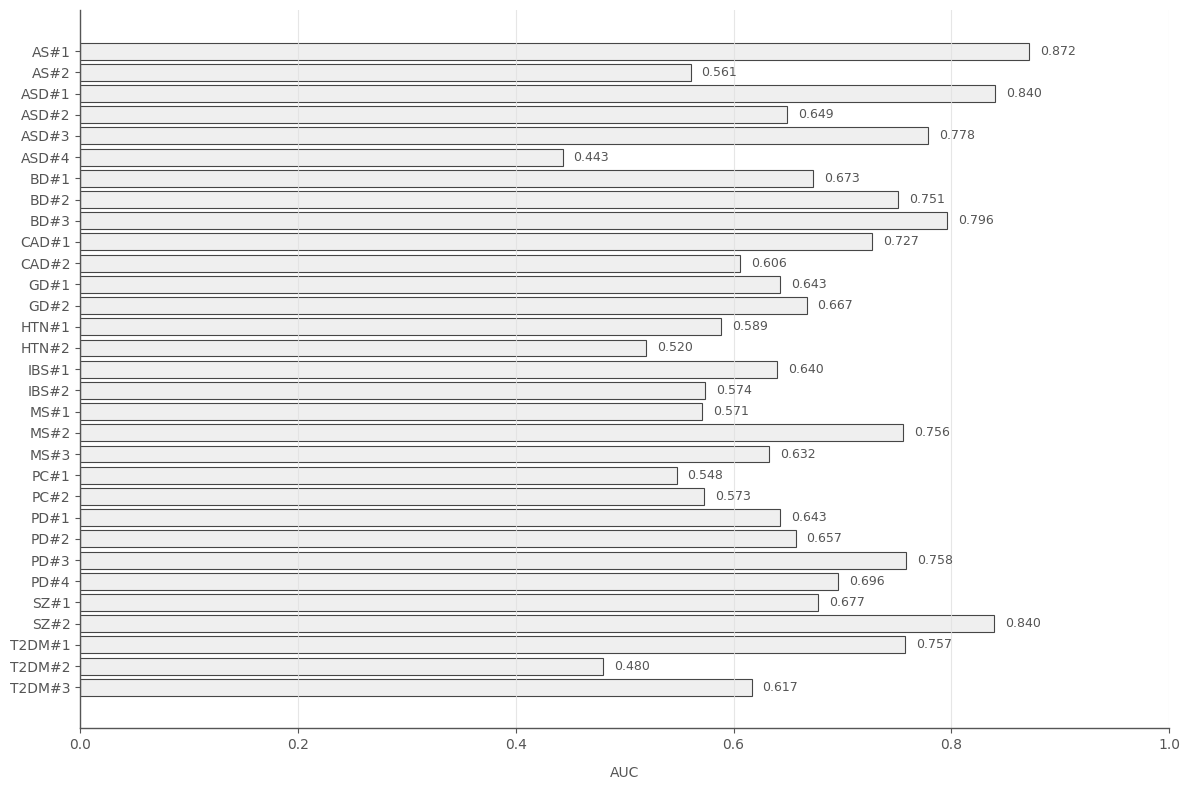

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 配置全局样式
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'axes.edgecolor': '#555555',    # 稍微柔和的坐标轴颜色
    'axes.linewidth': 1.0,
    'axes.labelcolor': '#555555',
    'xtick.color': '#555555',
    'ytick.color': '#555555'
})

# 读取数据
df = pd.read_csv("/home/dongbiao/all_study/script/script_leave_one_out/all_model_loo.csv")

# 数据预处理
df['study_order'] = df.groupby('disease_name_ab').cumcount() + 1
df['y_label'] = df['disease_name_ab'] + '#' + df['study_order'].astype(str)
sorted_indices = df.sort_values(['disease_name_ab', 'study_order']).index

# 创建画布
fig = plt.figure(figsize=(12, 8), dpi=100, facecolor='white')
ax = fig.add_subplot(111)

# 绘制柱状图（调整后的灰色系）
bars = ax.barh(y=df.loc[sorted_indices, 'y_label'],
              width=df.loc[sorted_indices, 'auc'],
              # width=df.loc[sorted_indices, 'AUC ROC'],
              color='#EEEEEE',      # 更浅的填充色
              edgecolor='#333333',  # 保持深灰边框
              linewidth=0.8,
              alpha=0.9)

# 数据标签设置
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.01, 
            bar.get_y() + bar.get_height()/2,
            f'{width:.3f}',
            va='center',
            color='#555555',        # 标签颜色与坐标轴统一
            fontsize=9)

# 坐标轴样式调整
ax.set_facecolor('white')
# 隐藏上、右边框
ax.spines[['top', 'right']].set_visible(False)
# 保持可见的边框颜色
ax.spines[['left', 'bottom']].set_color('#555555')

# 图表装饰
# ax.set_title('AUC Performance by Disease Study', 
#             pad=20, fontsize=14, color='#555555')
ax.set_xlabel('AUC', labelpad=10, color='#555555')
# ax.set_ylabel('Disease Study', labelpad=10, color='#555555')
ax.set_xlim(0, 1)
ax.grid(axis='x', color='#E0E0E0', alpha=0.8)  # 更柔和的网格线
ax.invert_yaxis()

plt.savefig("AUC_attention.png", 
          bbox_inches='tight', 
          dpi=300,
          facecolor='white')
# plt.savefig("AUC_RF.png", 
#           bbox_inches='tight', 
#           dpi=300,
#           facecolor='white')

# 优化布局
plt.tight_layout()
plt.show()
